In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
from keras.utils import np_utils


from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import robust_scale

def simpleAccuracy(pred, dummy_y):
    pred_Y = np.argmax(pred, axis=1)
    true_Y = np.argmax(dummy_y, axis=1)
    
    # this gives the measure of correctly tagged events, over the total
    return sum(pred_Y == true_Y)/len(true_Y)

In [407]:


variables = [
    ## best results with all variables, but should get pruned at some point...
    #'n_jet',
    #'n_central',
    #'n_fwd',
    'n_tau',
    'n_track',
    'st',
    #'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
    'lead_jet_eta',
    'sublead_jet_eta',
    'lead_btag_pt',
    'sublead_btag_pt',
    'lead_btag_eta',
    'sublead_btag_eta',
    ##'weight', # this does of course _not_ work 🤡 
]

In [480]:
## filter some data
df = pd.read_hdf('data/multiclass_input_loose.h5') # load data processed with ML_processor.py

df_MG = pd.read_hdf('data/multiclass_input_loose_MG.h5')

preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2))
#preselection = ((df['n_jet']>2) & (df['n_btag']>0)) # redundant selection, but we can filter on top


df = df[preselection]
df_MG = df_MG[preselection]

# cranking up stats by a mere 70% is not really worth it...
frames = [df, df_MG]
df_train = pd.concat(frames)

## maybe less overtraining??
#df_train = df

labels = df['label'].values
labels_train = df_train['label'].values

X = df_train[(labels_train<5)][variables]
labels_train = labels_train[labels_train<5]

labels = labels[labels<5]

In [481]:
encoder = LabelEncoder()
encoder.fit(labels_train)
dummy_y = np_utils.to_categorical(labels_train)

dummy_y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [482]:
robust = False

if not robust:
    X_mean, X_std = X.mean(), X.std()

    X_norm = copy.deepcopy(X)
    X_norm -= X_mean
    X_norm /= X_std

else:
    X_norm = robust_scale(X, quantile_range=(10.0, 90.0))

X_norm = np.nan_to_num(X_norm, 0) # this happens in like 10 events
X_norm

array([[-0.75828785, -0.38091857, -1.05401735, ..., -0.22269088,
         1.47460142,  0.96985524],
       [ 0.60498579, -0.38091857, -0.9008952 , ..., -0.70829316,
        -1.05508388,  1.49811873],
       [ 0.60498579, -0.38091857, -0.85178257, ..., -0.30111869,
         0.62203731, -0.08984835],
       ...,
       [-0.75828785, -0.38091857,  0.33551395, ..., -0.09834418,
        -1.09280378,  0.02690896],
       [-0.75828785, -0.38091857, -0.55103553, ...,  0.41204617,
         0.56517456,  1.13566978],
       [-0.75828785, -0.38091857, -0.84318629, ..., -0.60710908,
        -1.77270504,  0.88298284]])

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, dummy_y, train_size= int( 0.9*dummy_y.shape[0] ), random_state=42 )

In [484]:
from sklearn.utils import compute_class_weight

y_train_int = np.argmax(y_train, axis=1) # back to integers from one hot
y_test_int = np.argmax(y_test, axis=1) # back to integers from one hot

classWeight = compute_class_weight('balanced', classes=np.unique(y_train_int, axis=0), y=y_train_int) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.548535499735425,
 1: 0.9311669440701699,
 2: 0.7470770274280385,
 3: 1.4549267285861713,
 4: 12.957941176470587}

In [501]:
input_dim = len(variables)
out_dim = len(dummy_y[0])

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(54, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(54, activation='relu'))
    #model.add(tf.keras.layers.Dense(100, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    
    #opt = tf.keras.optimizers.SGD(lr=0.1)
    #opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.RMSprop(lr=0.001) ## performs best.
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model
 

model = baseline_model()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 54)                1296      
_________________________________________________________________
batch_normalization_48 (Batc (None, 54)                216       
_________________________________________________________________
dropout_48 (Dropout)         (None, 54)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 275       
Total params: 1,787
Trainable params: 1,679
Non-trainable params: 108
_________________________________________________________________


In [502]:
from ML.lrcurve import KerasLearningCurve

epochs = 50
batch_size = 5120
#batch_size = 1000
validation_split = 0.2

history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split,
    verbose = 0,
    class_weight = classWeight,
    callbacks = [KerasLearningCurve()]
)

In [503]:

if not robust:
    X_all = df[variables].values
    X_all -= X_mean
    X_all /= X_std
else:
    X_all = robust_scale(df[variables].values, quantile_range=(10.0, 90.0))
    
pred_all = model.predict( X_all )
pred_train = model.predict( X_train )
pred_test = model.predict( X_test )
pred_all[:,0]

array([0.20353107, 0.20570785, 0.1727504 , ..., 0.36259255, 0.37767255,
       0.40340886], dtype=float32)

In [504]:
df['score_topW'] = pred_all[:,0]
df['score_ttW'] = pred_all[:,1]
df['score_ttZ'] = pred_all[:,2]
df['score_ttH'] = pred_all[:,3]
df['score_ttbar'] = pred_all[:,4]
df['score_best'] = np.argmax(pred_all, axis=1)

In [591]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import processor, hist
from processor.std_acumulators import *

from plots.helpers import *

score_axis              = hist.Bin("score",          r"N", 20, 0, 1)
score_axis_v2           = hist.Bin("score",          r"N", 4, 0.2, 0.6)
p_axis                  = hist.Bin("p",             r"$p$ (GeV)", 10, 0, 3500)

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
#p_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
score_bins_coarse = hist.Bin('score', 'score', 10, 0, 1)
eta_bins = hist.Bin('eta', r'$\eta $', 50, -5.0, 5.0)

In [598]:
processes = {
    'topW_v2': df[df['label']==0],
    'TTW': df[df['label']==1],
    'TTZ': df[df['label']==2],
    'TTH': df[df['label']==3],
    'ttbar': df[df['label']==4],
}

sel_SR = ((df['n_jet']>0) & (df['n_central']>0) & (df['n_lep_tight']==2))
sel_topW = ((df['score_best']==0) & (df['n_lep_tight']==2))
sel_baseline = ((df['n_jet']>4) & (df['n_central']>3) & (df['met']>50) & (df['st']>600))

sel_ttW = ((df['score_best']==1))
sel_ttZ = ((df['score_best']==2))
sel_ttH = ((df['score_best']==3))
sel_ttbar = ((df['score_best']==4))

h_best_score = hist.Hist("best_score", dataset_axis, multiplicity_axis)
h_score_topW = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_Run2 = hist.Hist("score", dataset_axis, score_axis_v2)
h_score = hist.Hist("score", dataset_axis, score_axis)
h_jet_pt = hist.Hist("jet_pt", dataset_axis, pt_axis)
h_fwd_p = hist.Hist("fwd_p", dataset_axis, p_axis)


for proc in processes:
    h_best_score.fill(dataset=proc, multiplicity=processes[proc][sel_SR]['score_best'].values, weight=processes[proc][sel_SR]['weight'].values*60)
    h_score_topW.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*60)
    h_score_topW_Run2.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*137)
    h_score.fill(dataset=proc, score=processes[proc][sel_SR]["score_topW"].values, weight=processes[proc][sel_SR]["weight"].values*60)
    h_jet_pt.fill(dataset=proc, pt=processes[proc][sel_topW]["lead_jet_pt"].values, weight=processes[proc][sel_topW]["weight"].values*60)
    h_fwd_p.fill(dataset=proc, p=processes[proc][sel_baseline]["fwd_jet_p"].values, weight=processes[proc][sel_baseline]["weight"].values*60)

In [601]:
output = {
    'best_score': h_best_score,
    'score_topW': h_score_topW,
    'score_topW_Run2': h_score_topW_Run2,
    'score': h_score,
    'jet_pt': h_jet_pt,
    'fwd_p': h_fwd_p,
}

Data: 0 MC: 426.12


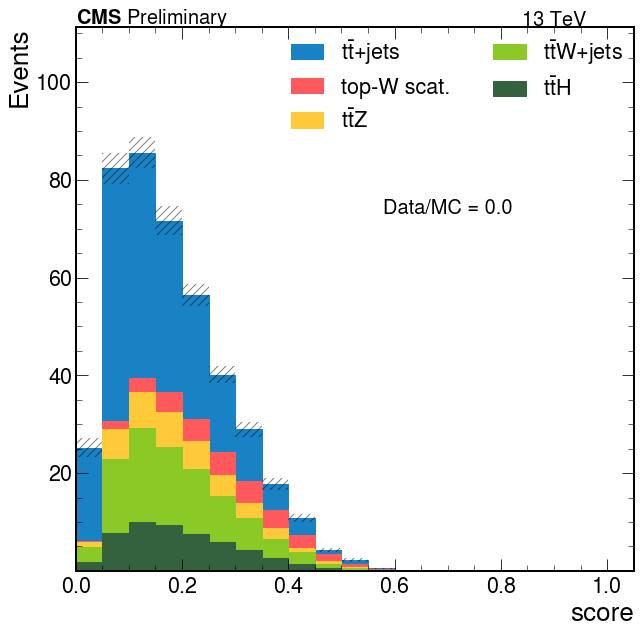

In [537]:
makePlot(output, 'score', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label='score',
        )

Data: 0 MC: 85.07


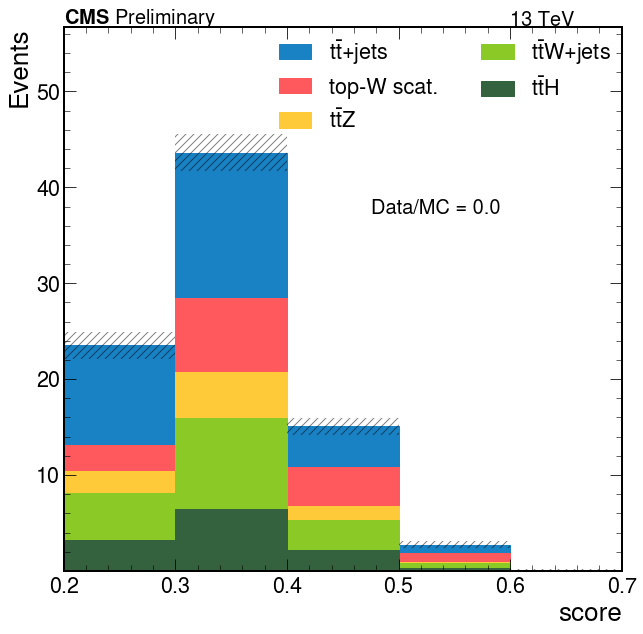

In [538]:
makePlot(output, 'score_topW', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label='score',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

Data: 0 MC: 85.07


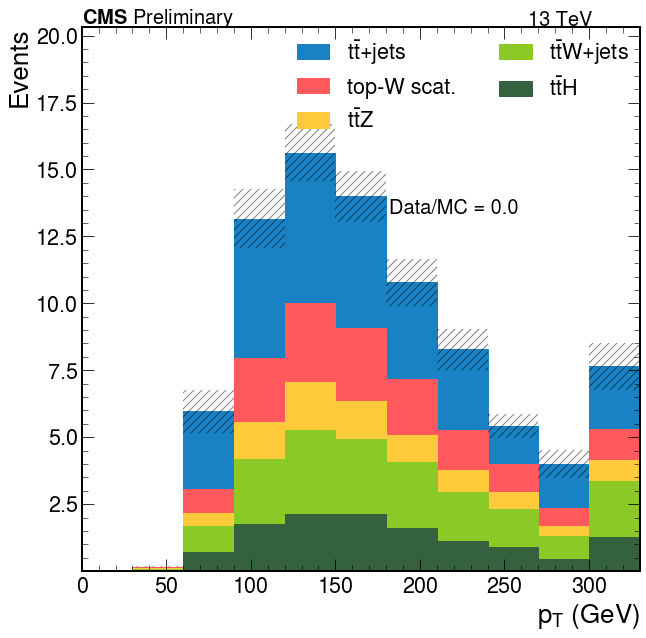

In [510]:
makePlot(output, 'jet_pt', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T\ (GeV)$',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

Data: 0 MC: 134.83


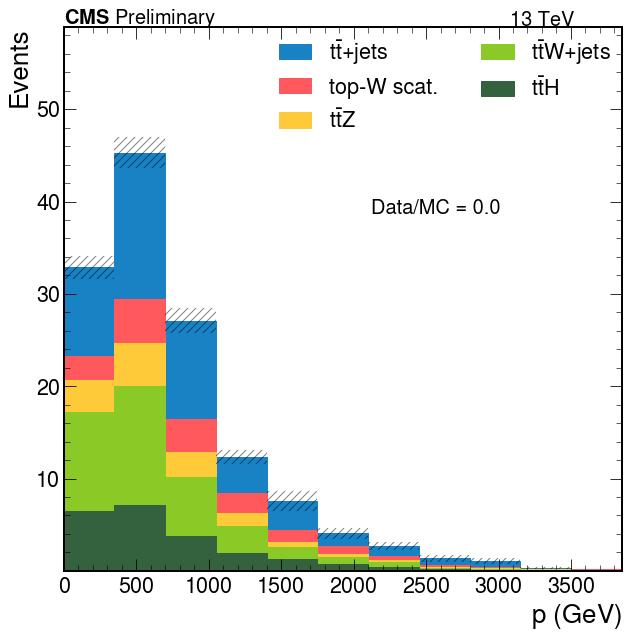

In [594]:
makePlot(output, 'fwd_p', 'p',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label=r'$p\ (GeV)$',
         #shape=True, ymax=0.4,
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

In [539]:
n_topW = h_score_topW['topW_v2'].sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]
n_all = h_score_topW.sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]

n_topW/(n_all-n_topW)

0.22216829210520014

In [540]:
h_score_topW.sum('score', overflow='over').values(overflow='over')

{('topW_v2',): 15.463336671273282,
 ('TTW',): 18.042682120138238,
 ('TTZ',): 8.767803128375817,
 ('TTH',): 12.110050830633554,
 ('ttbar',): 30.681370316888206}

In [541]:
df[((df['label']==0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.4))]['weight'].sum()*60

5.129287451609343

In [542]:
df[((df['label']>0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.4))]['weight'].sum()*60

12.792788502609369

In [527]:
df[((df['label']==0))]['weight'].sum()*60

31.287589070943795

In [528]:
df[((df['label']>0))]['weight'].sum()*60

394.83274425394495

Data: 0 MC: 426.12


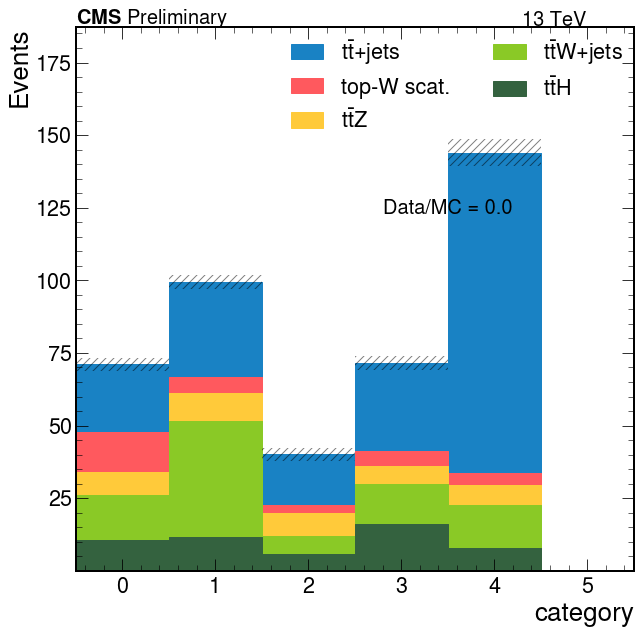

In [469]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='category',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier'
        )

Data: 0 MC: 426.12


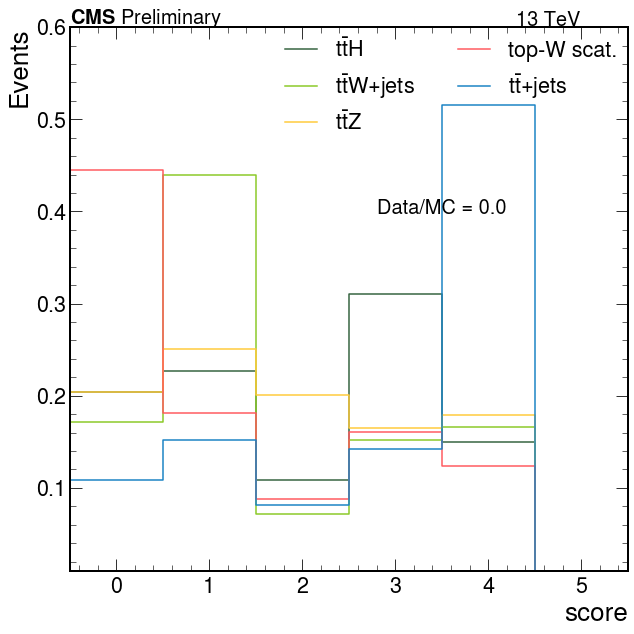

In [470]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='score', shape=True, ymax=0.6,
        )

## The below plots are unweighted!

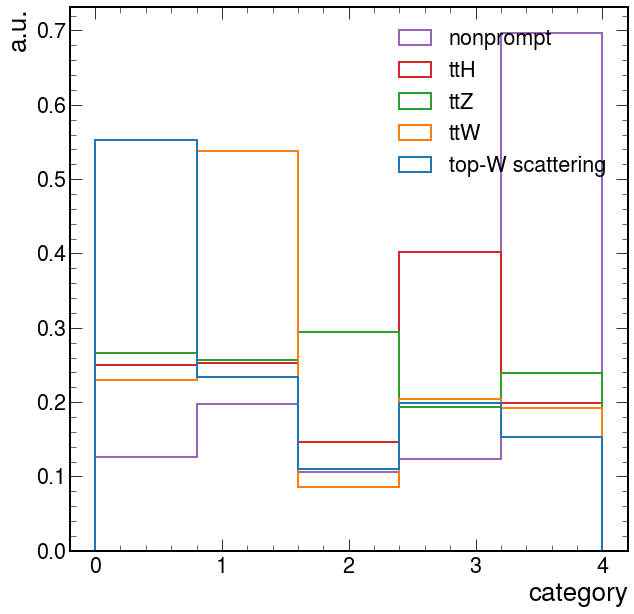

In [471]:
xbin = 5
_hist, _bins, _ax = plt.hist(
    [
        np.argmax(pred_train, axis=1)[(y_train_int==0)],
        np.argmax(pred_train, axis=1)[(y_train_int==1)],
        np.argmax(pred_train, axis=1)[(y_train_int==2)],
        np.argmax(pred_train, axis=1)[(y_train_int==3)],
        np.argmax(pred_train, axis=1)[(y_train_int==4)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH', 'nonprompt'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

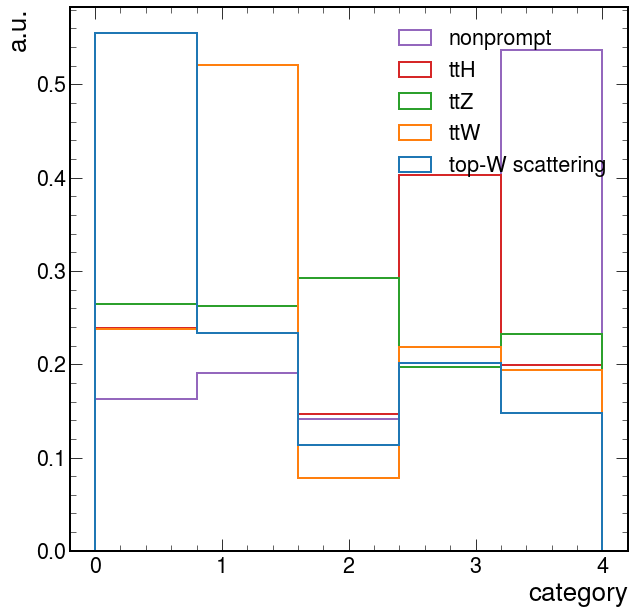

In [473]:
xbin = 5
_hist, _bins, _ax = plt.hist(
    [
        np.argmax(pred_test, axis=1)[(y_test_int==0)],
        np.argmax(pred_test, axis=1)[(y_test_int==1)],
        np.argmax(pred_test, axis=1)[(y_test_int==2)],
        np.argmax(pred_test, axis=1)[(y_test_int==3)],
        np.argmax(pred_test, axis=1)[(y_test_int==4)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH', 'nonprompt'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

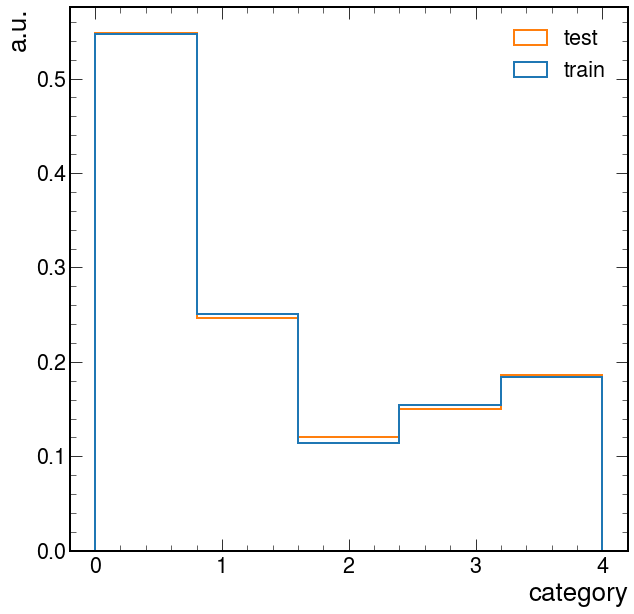

In [500]:
xbin = 5
_hist, _bins, _ax = plt.hist(
    [
        np.argmax(pred_train, axis=1)[(y_train_int==0)],
        np.argmax(pred_test, axis=1)[(y_test_int==0)],
    ], 
    xbin,
    log=False,
    label=['train' ,'test'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

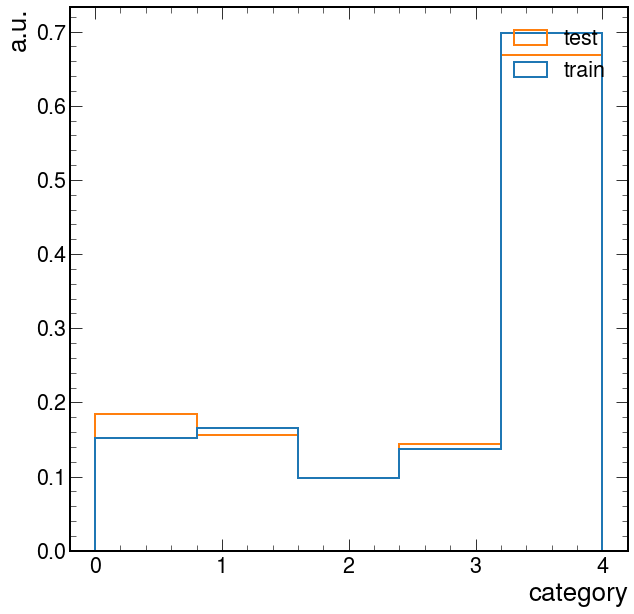

In [515]:
xbin = 5
_hist, _bins, _ax = plt.hist(
    [
        np.argmax(pred_train, axis=1)[(y_train_int==4)],
        np.argmax(pred_test, axis=1)[(y_test_int==4)],
    ], 
    xbin,
    log=False,
    label=['train' ,'test'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

In [602]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

SR_card = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_Run2 = makeCardFromHist(output, 'score_topW_Run2', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_BL = makeCardFromHist(output, 'fwd_p', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_stat = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='_stat', systematics=False)

Writing cards using histogram: score_topW
Signal expectation:           15.46
Non-prompt background:        30.68
t(t)X(X)/rare background:     38.92
Observation:                  85.07
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_card.txt
Writing cards using histogram: score_topW_Run2
Signal expectation:           35.31
Non-prompt background:        70.06
t(t)X(X)/rare background:     88.87
Observation:                  194.23
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_Run2_card.txt
Writing cards using histogram: fwd_p
Signal expectation:           16.31
Non-prompt background:        46.95
t(t)X(X)/rare background:     71.57
Observation:                  134.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card

In [572]:
card = dataCard()

In [605]:
results = card.nllScan(SR_card, rmin=0, rmax=3, npoints=61)
results_Run2 = card.nllScan(SR_card_Run2, rmin=0, rmax=3, npoints=61)
results_stat = card.nllScan(SR_card_stat, rmin=0, rmax=3, npoints=61)
results_BL = card.nllScan(SR_card_BL, rmin=0, rmax=3, npoints=61)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/380e687f-1e8e-4e94-aaf2-4db4b37477d3
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/22d00301-117e-4ed0-b2d7-5c9956352859
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/463822ab-2594-4e27-9af9-e1b0300dca2a
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/6f981392-f61f-4d45-94bf-f06d2c5fb6a0


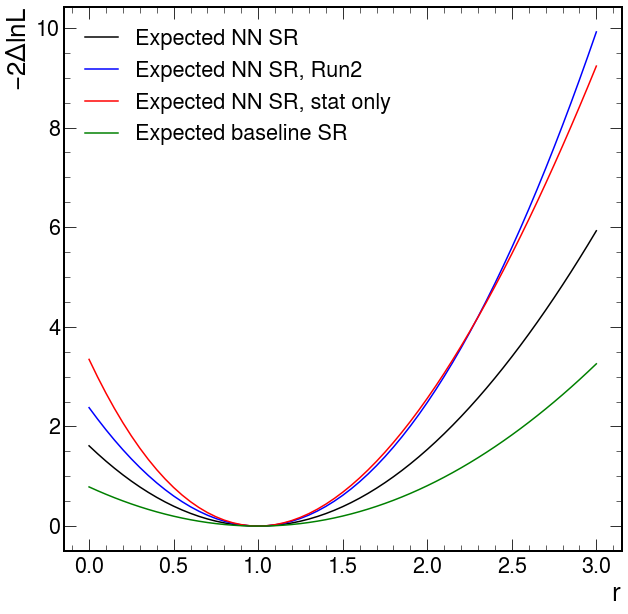

In [606]:
import mplhep
plt.style.use(mplhep.style.CMS)

plt.figure()

plt.plot(results['r'][1:], results['deltaNLL'][1:]*2, label=r'Expected NN SR', c='black')
plt.plot(results_Run2['r'][1:], results_Run2['deltaNLL'][1:]*2, label=r'Expected NN SR, Run2', c='blue')
plt.plot(results_stat['r'][1:], results_stat['deltaNLL'][1:]*2, label=r'Expected NN SR, stat only', c='red')
plt.plot(results_BL['r'][1:], results_BL['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()